<a href="https://colab.research.google.com/github/harshit0209/NeuralNetwroks/blob/master/FaceTrack_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip -qq install -U keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os, sys
dir = '/content/drive/My Drive/dataset'
if not os.path.exists(dir):
    !mkdir /content/drive/My\ Drive/dataset
    !wget http://virtualmist.com/dataset/lfwcrop_color.zip
    !cp lfwcrop_color.zip /content/drive/My\ Drive/dataset/lfwcrop_color.zip

--2020-05-28 15:41:37--  http://virtualmist.com/dataset/lfwcrop_color.zip
Resolving virtualmist.com (virtualmist.com)... 52.66.152.232
Connecting to virtualmist.com (virtualmist.com)|52.66.152.232|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152404390 (145M) [application/zip]
Saving to: ‘lfwcrop_color.zip’

lfwcrop_color.zip   100%[===================>] 145.34M  26.0MB/s    in 6.3s    

2020-05-28 15:41:43 (23.0 MB/s) - ‘lfwcrop_color.zip’ saved [152404390/152404390]



In [0]:
!cp /content/drive/My\ Drive/dataset/lfwcrop_color.zip  dataset.zip
!unzip -qq dataset.zip

In [0]:
BASE_PATH = 'lfwcrop_color/faces'

In [6]:
from __future__ import absolute_import, division, print_function
from keras.layers import LeakyReLU
import random
import os
import re
import numpy as np
import argparse
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import merge, Input, Subtract
from keras.models import Model
from keras.layers.noise import GaussianNoise
from keras.utils import generic_utils

Using TensorFlow backend.


In [0]:
from keras.callbacks import ModelCheckpoint


In [0]:
def identity_block(X, kernel, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    #X = LeakyReLU(alpha=0.1)(X) #not Converging
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (kernel, kernel), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    #X = LeakyReLU(alpha=0.1)(X) #not Converging
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    #X = LeakyReLU(alpha=0.1)(X) #not Converging
    X = Activation('relu')(X)    
    return X

In [0]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, LocallyConnected2D,GaussianDropout,ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [0]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [0]:
def cosine_distance(vecs, normalize=False):
    x, y = vecs
    if normalize:
        x = K.l2_normalize(x, axis=0)
        y = K.l2_normalize(x, axis=0)
    return K.prod(K.stack([x, y], axis=1), axis=1)

def cosine_distance_output_shape(shapes):
    return shapes[0]

def compute_accuracy(preds, labels):
    return labels[preds.ravel() < 0.5].mean()

In [0]:
INPUT_HEIGHT = 64
INPUT_WIDTH = 64
INPUT_CHANNELS = 3

In [0]:
from keras.layers.core import Lambda
def faceX(input_shape=(64, 64, 3), Classes=128):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    X_input = Input(shape=input_shape)
#Start Editing
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

   # X = LocallyConnected2D(filters=64, kernel_size=(7,7), strides=(1, 1), padding='valid', data_format=None, activation='tanh', 
    #                   use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
     #                  kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
      #                 kernel_constraint=None, bias_constraint=None)(X)
                         
    X = Conv2D(filters=64, kernel_size=(7,7), strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), 
               activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
               kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
               bias_constraint=None)(X)
    X = BatchNormalization()(X)
    X = Conv2D(filters=64, kernel_size=(7,7), strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), 
               activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
               kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
               bias_constraint=None)(X)
    
    #Normalize the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    #Reducing Internal Covariate Shift
    
    X = BatchNormalization(axis=3, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', 
                           gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', 
                           beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(X)
    
    X = Activation('relu')(X)
    

    #X = GaussianDropout(0.2)(X)
    X = AveragePooling2D((2,2))(X)
    X = Flatten()(X)

    X = Dense(units=Classes, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
              kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
              bias_constraint=None)(X)
#Stop Editing

#Part 2
    face_output = X
    #Model for Indv. Images(feature extraction)
    face_model = Model(X_input, X)
#Input the images
    face_left_input = Input(shape=(INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS),
                            dtype="float32", name="RefFace")
    face_right_input = Input(shape=(INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS),
                             dtype="float32", name="ActFace")
    
    #Passing the image for feature extraction
    face_left = face_model(face_left_input)
    face_right = face_model(face_right_input)



#Calculate difference
    distance = Lambda(cosine_distance, 
                      output_shape=cosine_distance_output_shape)([face_left, face_right])


    fc1 = Dense(128, kernel_initializer="glorot_uniform")(distance)
    fc1 = Dropout(0.2)(fc1)
    fc1 = Activation("relu")(fc1)

    pred = Dense(2, kernel_initializer="glorot_uniform")(fc1)
    pred = Activation("softmax")(pred)
    #complete
    model = Model(inputs=[face_left_input, face_right_input], outputs=pred)
    
    

    return model,face_model

In [14]:
# initialize the network
print("Creating model...")
input_shape = (64, 64, 3)
model,faceModel = faceX()

Creating model...


In [15]:
faceModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        9472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 64)        200768    
_________________________________________________________________
batch_normalization_2 (Batch (None, 58, 58, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 58, 58, 64)        0   

In [16]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RefFace (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
ActFace (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          7100352     RefFace[0][0]                    
                                                                 ActFace[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128)          0           model_1[1][0]              

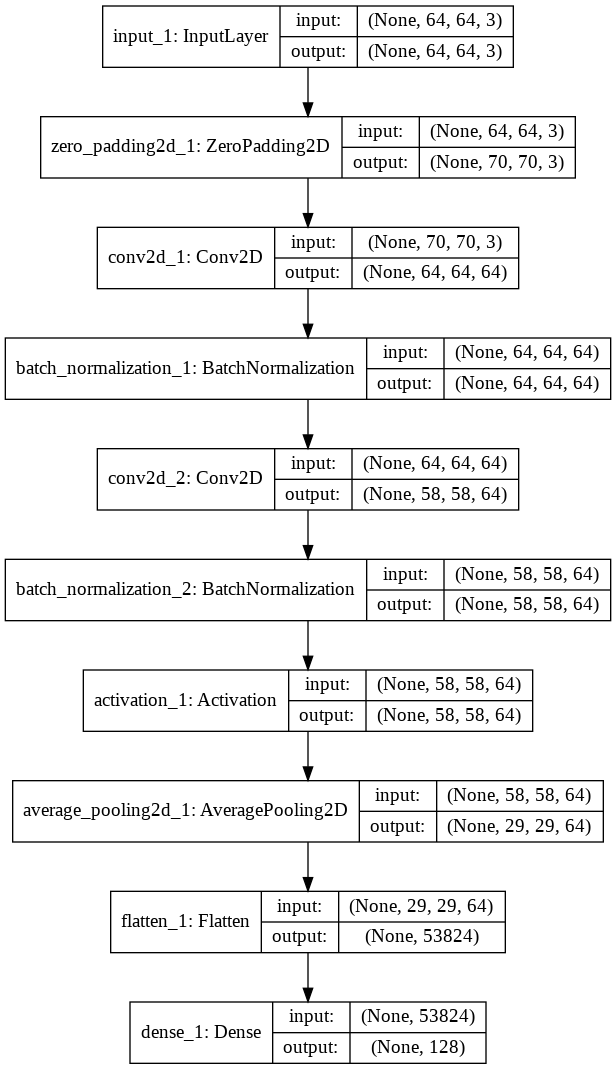

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(faceModel, to_file='model_plot.png', show_shapes=True)

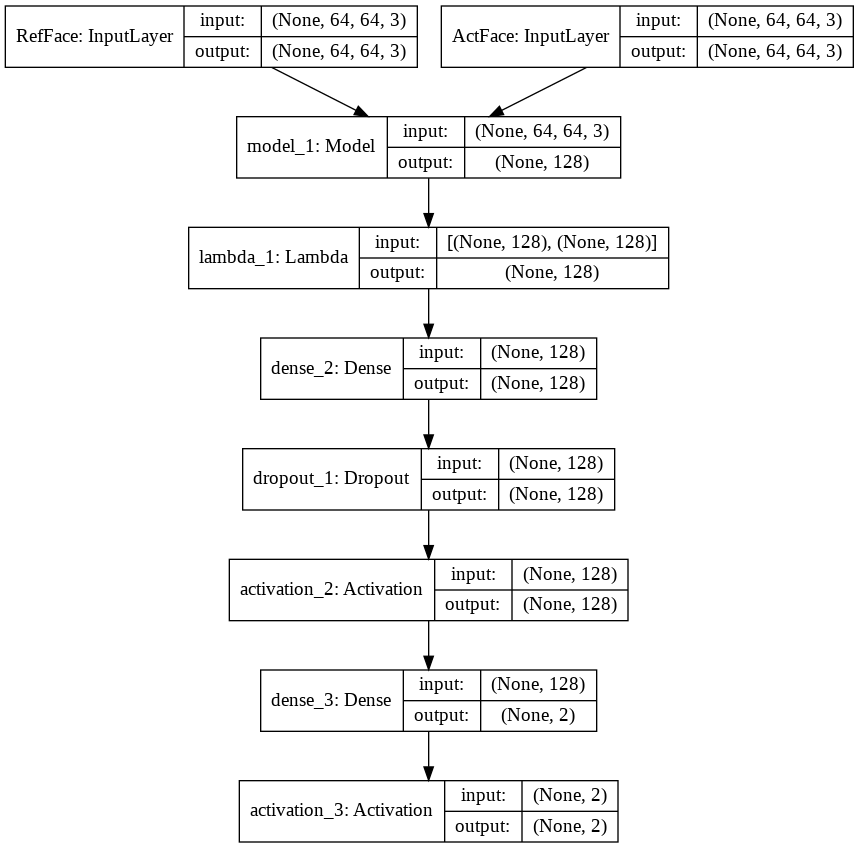

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='Mainmodel_plot.png', show_shapes=True)

In [19]:
import itertools
image_groups = {}
IMAGE_DIR ='lfwcrop_color/faces'
for image_name in os.listdir(IMAGE_DIR):
    base_name = image_name[0:-4]
    group_name = base_name.split('_0')[0]
    if group_name in image_groups:
        image_groups[group_name].append(image_name)
    else:
        image_groups[group_name] = [image_name]

num_sim = 0
image_triples = []
group_list = sorted(list(image_groups.keys()))
for i, g in enumerate(group_list):
    if num_sim % 100 == 0:
        print("Generated {:d} pos + {:d} neg = {:d} total image triples"
              .format(num_sim, num_sim, 2*num_sim), end="\r")
    images_in_group = image_groups[g]
    # generate similar pairs
    sim_pairs_it = itertools.combinations(images_in_group, 2)
    # for each similar pair, generate a different pair
    for ref_image, sim_image in sim_pairs_it:
        image_triples.append((ref_image, sim_image, 1))
        num_sim += 1
        while True:
            j = np.random.randint(low=0, high=len(group_list), size=1)[0]
            if j != i: break
        dif_image_candidates = image_groups[group_list[j]]
        k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
        dif_image = dif_image_candidates[k]
        image_triples.append((ref_image, dif_image, 0))
        
print("Generated {:d} pos + {:d} neg = {:d} total image triples, COMPLETE"
      .format(num_sim, num_sim, 2*num_sim))

Generated 242257 pos + 242257 neg = 484514 total image triples, COMPLETE


In [20]:
def image_triple_generator(image_triples, batch_size):
    while True:
        # loop once per epoch
        num_recs = len(image_triples)
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            # loop once per batch
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            yield [image_triples[i] for i in batch_indices]
            
triples_batch_gen = image_triple_generator(image_triples, 4)
next(triples_batch_gen)


[('Donald_Rumsfeld_0095.ppm', 'Donald_Rumsfeld_0102.ppm', 1),
 ('George_W_Bush_0117.ppm', 'George_W_Bush_0176.ppm', 1),
 ('George_W_Bush_0083.ppm', 'George_W_Bush_0336.ppm', 1),
 ('George_W_Bush_0210.ppm', 'Pamela_Melroy_0001.ppm', 0)]

In [0]:
def load_vectors(vector_file):
    vec_dict = {}
    fvec = open(vector_file, "rb")
    for line in fvec:
        image_name, image_vec = line.strip().split("\t")
        vec = np.array([float(v) for v in image_vec.split(",")])
        vec_dict[image_name] = vec
    fvec.close()
    return vec_dict

def train_test_split(triples, splits):
    assert sum(splits) == 1.0
    split_pts = np.cumsum(np.array([0.] + splits))
    indices = np.random.permutation(np.arange(len(triples)))
    shuffled_triples = [triples[i] for i in indices]
    data_splits = []
    for sid in range(len(splits)):
        start = int(split_pts[sid] * len(triples))
        end = int(split_pts[sid + 1] * len(triples))
        data_splits.append(shuffled_triples[start:end])
    return data_splits

In [0]:
def batch_to_vectors(batch, vec_size, vec_dict):
    X1 = np.zeros((len(batch), vec_size))
    X2 = np.zeros((len(batch), vec_size))
    Y = np.zeros((len(batch), 2))
    for tid in range(len(batch)):
        X1[tid] = vec_dict[batch[tid][0]]
        X2[tid] = vec_dict[batch[tid][1]]
        Y[tid] = [1, 0] if batch[tid][2] == 0 else [0, 1]
    return ([X1, X2], Y)
    
def data_generator(triples, vec_size, vec_dict, batch_size=32):
    while True:
        # shuffle once per batch
        indices = np.random.permutation(np.arange(len(triples)))
        num_batches = len(triples) // batch_size
        for bid in range(num_batches):
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [triples[i] for i in batch_indices]
            yield batch_to_vectors(batch, vec_size, vec_dict)

In [23]:
train_triples, val_triples, test_triples = train_test_split(image_triples, 
                                                            splits=[0.4, 0.3, 0.3])
print(len(train_triples), len(val_triples), len(test_triples))

193805 145354 145355


In [0]:
SEED = 50
#TRAIN_COUNT_EXAMPLES = 7000
#VALIDATION_COUNT_EXAMPLES = 500
EPOCHS = 10
BATCH_SIZE = 64
BATCH_SIZE_VAL = 32

In [0]:
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE

In [26]:
train_steps_per_epoch

3028

In [0]:
# Calling the compile method seems to mess with the seeds (theano problem?)
# Therefore they are reset here (numpy seeds seem to be unaffected)
# (Seems to still not make runs reproducible.)
random.seed(SEED)

In [0]:
import os, sys
dir = '/content/drive/My Drive/dataset/weights'
if not os.path.exists(dir):
    !mkdir /content/drive/My\ Drive/dataset/weights

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr=1e-2
    if epoch > 30:
        lr *= 1e-4
    elif epoch > 20:
        lr *= 1e-3
    elif epoch > 15:
        lr *= 1e-2
    elif epoch > 13:
        lr *= 1e-1

    print('Learning rate: ', lr)
    return lr

  
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


In [30]:
beta_1=0.99
beta_2=0.999
adam=Adam(lr=lr_schedule(0),beta_1=beta_1, beta_2=beta_2,decay=1e-6)
#if os.path.exists(dir):
 # model.load_weights(dir+"/faceTrackBest-v0.2.h5")

print("Compiling model...")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

 

Learning rate:  0.01
Compiling model...


In [0]:
checkpoint = ModelCheckpoint(filepath=dir+'/faceXBest-v0.2.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True)
checkpoint2 = ModelCheckpoint(filepath=dir+'/faceXLast-v0.2.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=True)
callbacks = [checkpoint,checkpoint2,lr_reducer, lr_scheduler]

In [0]:
import matplotlib.pyplot as plt
from keras.utils import np_utils
def load_image(image_name):
    if image_name not in image_cache:
        image = plt.imread(os.path.join(IMAGE_DIR, image_name)).astype(np.float32)
        #image = imresize(image, (64, 64))
        image = np.divide(image, 256)
        image_cache[image_name] = image
    return image_cache[image_name]
 
def generate_image_triples_batch(image_triples, batch_size, shuffle=False):
    while True:
        # loop once per epoch
        if shuffle:
            indices = np.random.permutation(np.arange(len(image_triples)))
        else:
            indices = np.arange(len(image_triples))
        shuffled_triples = [image_triples[ix] for ix in indices]
        num_batches = len(shuffled_triples) // batch_size
        for bid in range(num_batches):
            # loop once per batch
            images_left, images_right, labels = [], [], []
            batch = shuffled_triples[bid * batch_size : (bid + 1) * batch_size]
            for i in range(batch_size):
                lhs, rhs, label = batch[i]
                images_left.append(load_image(lhs))
                images_right.append(load_image(rhs))              
                labels.append(label)
            Xlhs = np.array(images_left)
            Xrhs = np.array(images_right)
            Y = np_utils.to_categorical(np.array(labels), num_classes=2)
            yield ([Xlhs, Xrhs], Y)

In [0]:
NUM_EPOCHS = 10

image_cache = {}
train_gen = generate_image_triples_batch(train_triples, BATCH_SIZE, shuffle=True)
val_gen = generate_image_triples_batch(val_triples, BATCH_SIZE, shuffle=False)
test_gen = generate_image_triples_batch(test_triples, BATCH_SIZE, shuffle=False)
num_train_steps = len(train_triples) // BATCH_SIZE
num_val_steps = len(val_triples) // BATCH_SIZE
num_test_steps = len(test_triples) // BATCH_SIZE

In [0]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=NUM_EPOCHS,verbose=1,
                              validation_data=val_gen,
                              validation_steps=num_val_steps,callbacks=callbacks)
#, workers=12,
 #                             use_multiprocessing=True,initial_epoch=0)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Epoch 1/10
Learning rate:  0.01
1958/3028 [==================>...........] - ETA: 3:43 - loss: 0.6960 - accuracy: 0.5010

In [0]:
prediction = model.evaluate_generator(test_gen,steps=num_test_steps,verbose=1,workers=8,use_multiprocessing=True)

In [0]:
prediction

In [0]:
"""history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,initial_epoch=10,
                              epochs=50,verbose=1,
                              validation_data=val_gen,
                              validation_steps=num_val_steps,callbacks=callbacks)
"""

In [0]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], color="r", label="train")
plt.plot(history.history["val_accuracy"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [0]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = dir+'/history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = dir+'/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [0]:
model_json = model.to_json()
with open(dir+"/model.json", "w") as json_file:
    json_file.write(model_json)